In [1]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import pandas as pd
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import gc


tqdm.pandas()

# ------------
CUDA_LAUNCH_BLOCKING="1"

In [2]:
df = pd.read_csv('../input/feedback-prize-english-language-learning/train.csv')
test_df = pd.read_csv('../input/feedback-prize-english-language-learning/test.csv')

In [3]:
test_df.head()

,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   text_id      3911 non-null   object 
 1   full_text    3911 non-null   object 
 2   cohesion     3911 non-null   float64
 3   syntax       3911 non-null   float64
 4   vocabulary   3911 non-null   float64
 5   phraseology  3911 non-null   float64
 6   grammar      3911 non-null   float64
 7   conventions  3911 non-null   float64
dtypes: float64(6), object(2)
memory usage: 244.6+ KB


In [5]:
tkz = Tokenizer(lower=False,oov_token='<OOV>')

In [6]:
tkz.fit_on_texts(df['full_text'])

In [7]:
class EssayDataset:
    def __init__(self, df, max_len, tokenizer, test=False):
        self.test = test
        self.max_length = max_len
        self.classes = ['cohesion','syntax','vocabulary','phraseology','grammar','conventions']
        self.texts = list(df['full_text'].values)
        if self.test is False:
            self.labels = df.loc[:,self.classes].values
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.texts)
    
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        text = self.tokenizer.texts_to_sequences([text])[0]
        text = pad_sequences([text],maxlen=self.max_length,padding='pre',truncating='post')[0]
        text = torch.tensor(text, dtype=torch.long)
        if self.test is False:
            label = self.labels[idx,:] / 5.
            label = torch.tensor(label, dtype=torch.float32)
            return text, label
        return text

In [8]:
sample_ds = EssayDataset(df,512,tkz)

In [9]:
sample_ds[0]

(tensor([    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [10]:
class RNNModel(pl.LightningModule):
    def __init__(self, config):
        super(RNNModel, self).__init__()
        self.save_hyperparameters()
        self.config = config
        self.vocab_size = self.config['vocab']
        self.embed_dim = self.config['embed_dim']
        self.hidden_dim = self.config['hidden_dim']
        self.seq_len = self.config['seq_len']
        self.n_layers = self.config['n_layers']
        self.output_dim = self.config['output_dim']
        
        self.lr = config['lr']
        
        self.embedding = nn.Embedding(self.vocab_size, self.embed_dim)
        
        self.lstm = nn.LSTM(input_size=self.embed_dim, 
                            hidden_size=self.hidden_dim,
                            num_layers = self.n_layers,
                            batch_first = True,
                            dropout = 0.3
                           )
        
        self.linear = nn.Linear(self.hidden_dim, self.output_dim)
        
        
        self.test_preds = []
        
#         self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.embedding(x)
        x, (h,c) = self.lstm(x)
        x = self.linear(h[-1])
        return x
    
    def loss_fn(self, outputs, targets):
        # MCRMSE: https://www.kaggle.com/competitions/feedback-prize-english-language-learning/discussion/348985
        colwise_mse = torch.mean(torch.square(targets - outputs), dim=0)
        loss = torch.mean(torch.sqrt(colwise_mse), dim=0)
        return loss
    

    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
#         scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3,gamma=0.1)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=20,eta_min=1e-6)
        return [optimizer], [scheduler]
    
    def training_step(self, batch, batch_idx):
        
        x, y = batch
        outputs = self(x)
        
        loss = self.loss_fn(outputs, y)

        self.log('train_loss', loss.item(), on_epoch=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        
        x,y = batch
        
        outputs = self(x)
        
        loss = self.loss_fn(outputs, y)
        
        self.log('val_loss', loss.item(), on_epoch=True)
        
    def test_step(self, batch, batch_idx):
        sample = batch
        preds = self(sample) * 5.
        self.test_preds.append(preds.detach().cpu())
        
    def get_predictions(self):
        return torch.cat(self.test_preds).numpy()


In [11]:
score_cols = ['cohesion','syntax','vocabulary','phraseology','grammar','conventions']
df['total_score'] = df.loc[:,score_cols].sum(axis=1)

In [12]:
config = {
    'vocab': len(tkz.word_index),
    'embed_dim': 13,
    'hidden_dim': 8,
    'seq_len': 512,
    'n_layers': 4,
    'output_dim': len(score_cols),
    'lr': 3e-4,
    'epochs': 25,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'batch_size': 16,
    'seed': 1357,
    'model_name': 'lstm-embeddings'
}
print(config)

{'vocab': 25089, 'embed_dim': 13, 'hidden_dim': 8, 'seq_len': 512, 'n_layers': 4, 'output_dim': 6, 'lr': 0.0003, 'epochs': 25, 'device': 'cuda', 'batch_size': 16, 'seed': 1357, 'model_name': 'lstm-embeddings'}


In [13]:
def prepare_datasets(df,test_size=0.2):
    train_df, val_df = train_test_split(df, 
                                         test_size=test_size, 
                                         shuffle=True,
                                         random_state = config['seed']
                                        )
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)

    train_ds = EssayDataset(train_df, config['seq_len'], tkz)
    val_ds = EssayDataset(val_df, config['seq_len'], tkz)

    train_loader = torch.utils.data.DataLoader(train_ds,batch_size=config['batch_size'],shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_ds,batch_size=config['batch_size'])
    
    return train_loader, val_loader

In [14]:
train_loader, val_loader = prepare_datasets(df)
len(train_loader), len(val_loader)

(196, 49)

In [15]:
test_ds = EssayDataset(test_df,config['seq_len'],tkz,test=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1, num_workers=1, shuffle=False)

In [16]:
_x,_y = next(iter(train_loader))
_x.shape, _y.shape

(torch.Size([16, 512]), torch.Size([16, 6]))

In [17]:
model = RNNModel(config)

In [18]:
trainer = pl.Trainer(accelerator='gpu', 
                     callbacks=[
                         EarlyStopping(monitor="val_loss", 
                                       mode="min",
                                       patience=5,
                                      )
                     ],
                     max_epochs = config['epochs']
                    )

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

0.025118864315095822


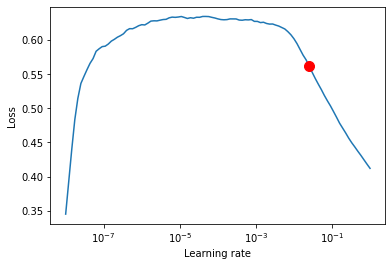

In [19]:
lr_finder = trainer.tuner.lr_find(model, train_loader, val_loader)

# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
print(new_lr)

In [20]:
model.hparams.lr = new_lr

In [21]:
model.hparams

"config": {'vocab': 25089, 'embed_dim': 13, 'hidden_dim': 8, 'seq_len': 512, 'n_layers': 4, 'output_dim': 6, 'lr': 0.0003, 'epochs': 25, 'device': 'cuda', 'batch_size': 16, 'seed': 1357, 'model_name': 'lstm-embeddings'}
"lr":     0.025118864315095822

In [22]:
trainer.fit(model, train_loader, val_loader)
metrics = trainer.logged_metrics

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [23]:
logs = {
    'train_loss': metrics['train_loss_epoch'].item(),
    'val_loss': metrics['val_loss'].item()
}

In [24]:
logs

{'train_loss': 0.1277388632297516, 'val_loss': 0.13097631931304932}

In [25]:
trainer.test(model,test_loader)

Testing: 0it [00:00, ?it/s]

[{}]

In [26]:
p = model.get_predictions()

In [27]:
p.shape

(3, 6)

In [28]:
submission = pd.DataFrame({'text_id':test_df['text_id']})
submission[score_cols] = p

In [29]:
submission

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,3.170367,3.057156,3.267235,3.157641,3.067789,3.115009
1,000BAD50D026,3.199883,3.083048,3.289579,3.183536,3.096803,3.147967
2,00367BB2546B,3.091121,2.984681,3.205660,3.084488,2.980039,3.018410


In [30]:
submission.to_csv('submission.csv',index=False)